In [1]:
import numpy as np
import pandas as pd

from money_parser import price_dec
import lightgbm as lgbm

from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
def curr_to_float(v): return float(price_dec(v)) if v else v
def tf_to_10(v): return 1 if v == 't' else 0
def nulls_to_0(v): return float(0 if (pd.isnull(v) or v == '') else v)

converters_to_columns = [
    (curr_to_float, ['price', 'weekly_price', 'monthly_price']),
    (tf_to_10, ['instant_bookable', 'host_is_superhost']),
    (nulls_to_0, ['bedrooms', 'bathrooms'])
]

converters = {col: conv for conv, cols in converters_to_columns for col in cols}

df = pd.read_csv('data/listings.csv', index_col='id', converters=converters)

/home/abhivik/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
imp_df = df.copy()
imp_df = imp_df[['host_is_superhost',
'neighbourhood',
'accommodates',
'bed_type',
'bathrooms',
'bedrooms',
'room_type',
'property_type',
# 'amenities',
'number_of_reviews',
'price']]

In [4]:
imp_df['neighbourhood'], neighbourhood_map = pd.factorize(df['neighbourhood'])
imp_df['property_type'], property_type_map = pd.factorize(df['property_type'])
imp_df['bed_type'], bed_type_map = pd.factorize(df['bed_type'])
imp_df['room_type'], room_type_map = pd.factorize(df['room_type'])

In [5]:
display(imp_df)

,host_is_superhost,neighbourhood,accommodates,bed_type,bathrooms,bedrooms,room_type,property_type,number_of_reviews,price
id,,,,,,,,,,
3647,0,0,2,0,1.0,1.0,0,0,0,150.0
3831,0,1,3,1,1.0,1.0,1,1,279,89.0
5022,0,2,1,1,1.0,0.0,1,0,9,80.0
5099,0,3,2,1,1.0,1.0,1,0,75,200.0
5121,0,4,2,2,0.0,1.0,0,0,49,60.0
...,...,...,...,...,...,...,...,...,...,...
38564068,0,4,7,1,2.0,3.0,1,0,0,199.0
38564524,0,5,2,1,1.0,0.0,1,0,0,175.0
38566777,0,1,1,1,1.0,1.0,0,0,0,35.0


In [6]:
X = imp_df.drop('price', axis='columns').values
y = imp_df['price'].values

const_params = {
    'objective':                      'regression', 
    'booster':                        'goss',
    'metric':                         'rmse',
    'n_jobs':                         -1
}

tuning_parameters = {
    'random_state': [0]
}

grid = GridSearchCV(lgbm.LGBMRegressor(**const_params), 
                          tuning_parameters, 
                          cv=StratifiedKFold(5),  
                          n_jobs=-1)

grid.fit(X, y)

# print(f'Best parameters {grid.best_params_}.')
print(f'Best RMSE is {grid.best_score_}.')

/home/abhivik/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/abhivik/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best RMSE is 0.16724712586644896.


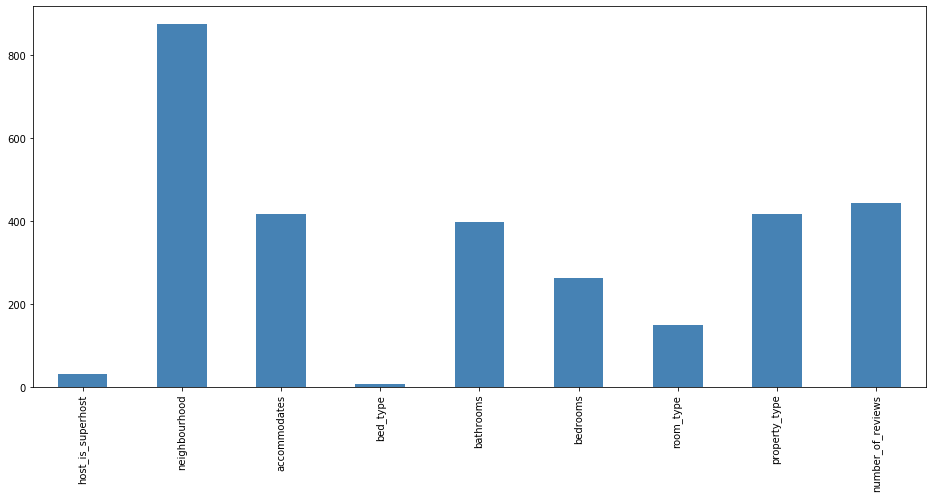

In [8]:
(pd.Series(grid.best_estimator_.feature_importances_, 
           index=imp_df.drop('price', axis='columns').columns.tolist())
 .plot.bar(color='steelblue', figsize=(16, 7)));